In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import numpy as np
import pandas as pd
from divexplorer_generalized.FP_Divergence import FP_Divergence

# Import data

In [4]:
dataset_name = "adult"

In [5]:
DATASET_DIR = os.path.join(os.path.curdir, "datasets")

def import_process_adult(discretize=False, bins=3, inputDir=DATASET_DIR):
    education_map = {
        "10th": "Dropout",
        "11th": "Dropout",
        "12th": "Dropout",
        "1st-4th": "Dropout",
        "5th-6th": "Dropout",
        "7th-8th": "Dropout",
        "9th": "Dropout",
        "Preschool": "Dropout",
        "HS-grad": "High School grad",
        "Some-college": "High School grad",
        "Masters": "Masters",
        "Prof-school": "Prof-School",
        "Assoc-acdm": "Associates",
        "Assoc-voc": "Associates",
    }
    occupation_map = {
        "Adm-clerical": "Admin",
        "Armed-Forces": "Military",
        "Craft-repair": "Blue-Collar",
        "Exec-managerial": "White-Collar",
        "Farming-fishing": "Blue-Collar",
        "Handlers-cleaners": "Blue-Collar",
        "Machine-op-inspct": "Blue-Collar",
        "Other-service": "Service",
        "Priv-house-serv": "Service",
        "Prof-specialty": "Professional",
        "Protective-serv": "Other",
        "Sales": "Sales",
        "Tech-support": "Other",
        "Transport-moving": "Blue-Collar",
    }
    married_map = {
        "Never-married": "Never-Married",
        "Married-AF-spouse": "Married",
        "Married-civ-spouse": "Married",
        "Married-spouse-absent": "Separated",
        "Separated": "Separated",
        "Divorced": "Separated",
        "Widowed": "Widowed",
    }

    country_map = {
        "Cambodia": "SE-Asia",
        "Canada": "British-Commonwealth",
        "China": "China",
        "Columbia": "South-America",
        "Cuba": "Other",
        "Dominican-Republic": "Latin-America",
        "Ecuador": "South-America",
        "El-Salvador": "South-America",
        "England": "British-Commonwealth",
        "France": "Euro_1",
        "Germany": "Euro_1",
        "Greece": "Euro_2",
        "Guatemala": "Latin-America",
        "Haiti": "Latin-America",
        "Holand-Netherlands": "Euro_1",
        "Honduras": "Latin-America",
        "Hong": "China",
        "Hungary": "Euro_2",
        "India": "British-Commonwealth",
        "Iran": "Other",
        "Ireland": "British-Commonwealth",
        "Italy": "Euro_1",
        "Jamaica": "Latin-America",
        "Japan": "Other",
        "Laos": "SE-Asia",
        "Mexico": "Latin-America",
        "Nicaragua": "Latin-America",
        "Outlying-US(Guam-USVI-etc)": "Latin-America",
        "Peru": "South-America",
        "Philippines": "SE-Asia",
        "Poland": "Euro_2",
        "Portugal": "Euro_2",
        "Puerto-Rico": "Latin-America",
        "Scotland": "British-Commonwealth",
        "South": "Euro_2",
        "Taiwan": "China",
        "Thailand": "SE-Asia",
        "Trinadad&Tobago": "Latin-America",
        "United-States": "United-States",
        "Vietnam": "SE-Asia",
    }
    # as given by adult.names
    column_names = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income-per-year",
    ]

    #check_dataset_availability("credit-g.csv", inputDir=inputDir)
    train = pd.read_csv(
        os.path.join(inputDir, "adult.data"),
        header=None,
        names=column_names,
        skipinitialspace=True,
        na_values="?",
    )

    #check_dataset_availability("adult.test", inputDir=inputDir)

    test = pd.read_csv(
        os.path.join(inputDir, "adult.test"),
        header=0,
        names=column_names,
        skipinitialspace=True,
        na_values="?",
    )
    dt = pd.concat([test, train], ignore_index=True)
    dt["education"] = dt["education"].replace(education_map)
    dt.drop(columns=["education-num", "fnlwgt"], inplace=True)
    dt["occupation"] = dt["occupation"].replace(occupation_map)
    dt["marital-status"] = dt["marital-status"].replace(married_map)
    dt["native-country"] = dt["native-country"].replace(country_map)

    dt.rename(columns={"income-per-year": "class"}, inplace=True)
    dt["class"] = (
        dt["class"].astype("str").replace({">50K.": ">50K", "<=50K.": "<=50K"})
    )
    dt.dropna(inplace=True)
    dt.reset_index(drop=True, inplace=True)
    if discretize:
        dt = KBinsDiscretizer_continuos(dt, bins=bins)
    dt.drop(columns=["native-country"], inplace=True)
    return dt, {"N": "<=50K", "P": ">50K"}


In [6]:
df, class_map = import_process_adult()

In [7]:
df.describe()

,age,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1101.430344,88.595418,40.938017
std,13.217870,7506.430084,404.956092,12.007508
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,47.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


In [8]:
from sklearn.preprocessing import LabelEncoder


attributes = df.columns.drop("class")
X = df[attributes].copy()
y = df["class"].copy()

encoders = {}
for column in attributes:
    if df.dtypes[column] == np.object:
        print(column)
        le = LabelEncoder()
        X[column] = le.fit_transform(df[column])
        encoders[column] = le

workclass
education
marital-status
occupation
relationship
race
sex


# Train and predict with RF classifier

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier




clf = RandomForestClassifier(random_state=42)


k_cv = 10


cv = StratifiedKFold(n_splits=k_cv, random_state=42, shuffle=True
            )  # Added to fix the random state  #Added shuffle=True for new version sklearn, Value Error
       
y_predicted = cross_val_predict(clf, X, y.values, cv=cv)

In [10]:
df["predicted"] = y_predicted

In [11]:
df.shape,  list(df.describe().columns)

((45222, 13), ['age', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [12]:
df.shape

(45222, 13)

# Tree divergence

In [13]:
true_class_name = "class"
pred_class_name = "predicted"
cols_c = [true_class_name, pred_class_name]

In [14]:
continuous_attributes = list(df.describe().columns)

In [15]:
df_analyze = df.copy()

In [16]:
min_support_tree = 0.1

In [17]:
metric = "d_fpr"

In [18]:
type_criterion="divergence_criterion"

type_experiment = "one_at_time"

In [19]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=min_support_tree,
    metric=metric,
    class_map=class_map,
    continuous_attributes=list(continuous_attributes),
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion='entropy', #type_criterion,
    #minimal_gain = 0.0015
)

In [20]:
tree_discr.printDiscretizationTrees(round_v =2, show_condition = True)

age
 root s=1.00 --> d_fpr=0.00
         age<=27 s=0.24 --> d_fpr=-0.07
                 age<=22 s=0.11 --> d_fpr=-0.08
                 age>22 s=0.13 --> d_fpr=-0.07
         age>27 s=0.76 --> d_fpr=0.03
                 age<=35 s=0.22 --> d_fpr=-0.01
                         age<=31 s=0.11 --> d_fpr=-0.02
                         age>31 s=0.11 --> d_fpr=0.01
                 age>35 s=0.55 --> d_fpr=0.05
                         age<=56 s=0.44 --> d_fpr=0.06
                                 age<=46 s=0.28 --> d_fpr=0.05
                                         age<=39 s=0.11 --> d_fpr=0.04
                                         age>39 s=0.17 --> d_fpr=0.05
                                 age>46 s=0.16 --> d_fpr=0.08
                         age>56 s=0.11 --> d_fpr=0.02

hours-per-week
 root s=1.00 --> d_fpr=0.00
         hours-per-week<=40 s=0.70 --> d_fpr=-0.03
                 hours-per-week<=36 s=0.20 --> d_fpr=-0.06
                 hours-per-week>36 s=0.49 --> d_fpr=-0.01
    

# Extract patterns

In [22]:
min_sup_divergences = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]

In [23]:
import time

In [24]:
out_support = {}
out_time = {}

## Base

In [25]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)
import time


for keep in [True, False]:
    if keep:
        keep_items = tree_discr.get_keep_items_associated_with_divergence()
        keep_str = "_pruned"
    else:
        keep_items = None
        keep_str = ""

    for min_sup_divergence in min_sup_divergences:
        s_time = time.time()
        FP_fm = extract_divergence_generalized(
            df_analyze,
            discretizations,
            generalization_dict,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=False,
            true_class_name=true_class_name,
            predicted_class_name=pred_class_name,
            class_map=class_map,
            metrics_divergence = ["d_fpr"],
            FPM_type="fpgrowth",
            save_in_progress = False, 
            keep_only_positive_divergent_items=keep_items
        )

        key = "base" + keep_str
        
        out_time.setdefault(min_sup_divergence, {})[key] = time.time()-s_time

        fp_divergence_i = FP_Divergence(FP_fm, metric=metric)

        most_divergent = (
            fp_divergence_i.getDivergence(th_redundancy=0)
            .sort_values(
                [fp_divergence_i.metric, fp_divergence_i.t_value_col], ascending=False
            )
            .head(1)
        )
        out_support.setdefault(min_sup_divergence, {})[key] = most_divergent

## Generalized

In [26]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)
import time


for keep in [True, False]:
    if keep:
        keep_items = tree_discr.get_keep_items_associated_with_divergence()
        keep_str = "_pruned"
    else:
        keep_items = None
        keep_str = ""

    for min_sup_divergence in min_sup_divergences:
        s_time = time.time()
        FP_fm = extract_divergence_generalized(
            df_analyze,
            discretizations,
            generalization_dict,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=True,
            true_class_name=true_class_name,
            predicted_class_name=pred_class_name,
            class_map=class_map,
            metrics_divergence = ["d_fpr"],
            FPM_type="fpgrowth",
            save_in_progress = False, 
            keep_only_positive_divergent_items=keep_items
        )

        key = "generalized" + keep_str
        
        out_time.setdefault(min_sup_divergence, {})[key] = time.time()-s_time

        fp_divergence_i = FP_Divergence(FP_fm, metric=metric)

        most_divergent = (
            fp_divergence_i.getDivergence(th_redundancy=0)
            .sort_values(
                [fp_divergence_i.metric, fp_divergence_i.t_value_col], ascending=False
            )
            .head(1)
        )
        out_support.setdefault(min_sup_divergence, {})[key] = most_divergent

1 10000
1 10000
2 20000
1 10000


# Results

In [27]:
out_time

{0.01: {'base_pruned': 1.9707591533660889,
  'base': 2.7082858085632324,
  'generalized_pruned': 3.9245986938476562,
  'generalized': 6.670316219329834},
 0.02: {'base_pruned': 1.6163930892944336,
  'base': 2.104903221130371,
  'generalized_pruned': 2.8208253383636475,
  'generalized': 4.292623996734619},
 0.03: {'base_pruned': 1.5616815090179443,
  'base': 1.8298895359039307,
  'generalized_pruned': 2.3996338844299316,
  'generalized': 3.3567299842834473},
 0.04: {'base_pruned': 1.4527008533477783,
  'base': 1.7903952598571777,
  'generalized_pruned': 2.229482412338257,
  'generalized': 2.956446647644043},
 0.05: {'base_pruned': 1.3897509574890137,
  'base': 1.649228572845459,
  'generalized_pruned': 2.002650260925293,
  'generalized': 2.713425874710083},
 0.1: {'base_pruned': 1.1511075496673584,
  'base': 1.3940551280975342,
  'generalized_pruned': 1.6407344341278076,
  'generalized': 2.1397621631622314},
 0.15: {'base_pruned': 0.9787774085998535,
  'base': 1.0242948532104492,
  'gen

In [28]:
for k in out_support:
    print(k)
    for t_gen in out_support[k]:
        print(t_gen)
        display(out_support[k][t_gen])

0.01
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
3959,0.010946,"(occupation=White-Collar, workclass=Private, a...",18,72,50,355,4,495.0,0.8,0.721885,17.031069


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
7144,0.010946,"(occupation=White-Collar, workclass=Private, a...",18,72,50,355,4,495.0,0.8,0.721885,17.031069


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
12189,0.010614,"(race=White, hours-per-week=[41-53], marital-s...",20,80,42,338,5,480.0,0.8,0.721885,17.958778


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
26105,0.010614,"(race=White, hours-per-week=[41-53], marital-s...",20,80,42,338,5,480.0,0.8,0.721885,17.958778


0.02
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
1939,0.021317,"(age=[40-46], education=Bachelors, marital-sta...",85,167,96,616,3,964.0,0.662698,0.584584,19.658587


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
3185,0.021317,"(age=[40-46], education=Bachelors, marital-sta...",85,167,96,616,3,964.0,0.662698,0.584584,19.658587


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
6022,0.020167,"(race=White, age=>=36, marital-status=Married,...",57,137,82,636,6,912.0,0.706186,0.628071,19.228055


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
12194,0.020145,"(marital-status=Married, occupation=Profession...",58,161,100,592,4,911.0,0.73516,0.657045,22.030985


0.03
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
1138,0.031799,"(marital-status=Married, education=Masters)",132,194,126,986,2,1438.0,0.595092,0.516977,19.04869


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
1786,0.031799,"(marital-status=Married, education=Masters)",132,194,126,986,2,1438.0,0.595092,0.516977,19.04869


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
3205,0.032727,"(age=[36-56], race=White, marital-status=Marri...",107,232,152,989,5,1480.0,0.684366,0.606251,24.016593


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
6321,0.032727,"(age=[36-56], race=White, marital-status=Marri...",107,232,152,989,5,1480.0,0.684366,0.606251,24.016593


0.04
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
448,0.061674,"(race=White, occupation=Professional, marital-...",357,435,317,1680,3,2789.0,0.549242,0.471128,26.598005


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
659,0.061674,"(race=White, occupation=Professional, marital-...",357,435,317,1680,3,2789.0,0.549242,0.471128,26.598005


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
2250,0.042391,"(age=[36-56], occupation=Professional, marital...",149,298,192,1278,3,1917.0,0.666667,0.588552,26.379188


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
4400,0.042391,"(age=[36-56], occupation=Professional, marital...",149,298,192,1278,3,1917.0,0.666667,0.588552,26.379188


0.05
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
448,0.061674,"(race=White, occupation=Professional, marital-...",357,435,317,1680,3,2789.0,0.549242,0.471128,26.598005


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
659,0.061674,"(race=White, occupation=Professional, marital-...",357,435,317,1680,3,2789.0,0.549242,0.471128,26.598005


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
1722,0.051059,"(age=[36-56], education=Bachelors, marital-sta...",229,391,243,1446,3,2309.0,0.630645,0.55253,28.464784


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
3361,0.051059,"(age=[36-56], education=Bachelors, marital-sta...",229,391,243,1446,3,2309.0,0.630645,0.55253,28.464784


0.1
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
215,0.10245,"(race=White, relationship=Husband, hours-per-w...",1396,633,697,1907,3,4633.0,0.311976,0.233861,22.54118


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
297,0.10245,"(race=White, relationship=Husband, hours-per-w...",1396,633,697,1907,3,4633.0,0.311976,0.233861,22.54118


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
622,0.102096,"(hours-per-week=>=41, race=White, relationship...",1060,700,677,2180,4,4617.0,0.397727,0.319612,27.214797


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
1081,0.102096,"(hours-per-week=>=41, race=White, relationship...",1060,700,677,2180,4,4617.0,0.397727,0.319612,27.214797


0.15
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
11,0.419707,"(race=White, marital-status=Married)",8047,2172,2925,5836,2,18980.0,0.212545,0.13443,31.266608


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
12,0.419707,"(race=White, marital-status=Married)",8047,2172,2925,5836,2,18980.0,0.212545,0.13443,31.266608


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
286,0.15634,"(hours-per-week=>=41, relationship=Husband, ag...",1983,1018,1068,3001,4,7070.0,0.33922,0.261105,29.814274


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
465,0.15634,"(hours-per-week=>=41, relationship=Husband, ag...",1983,1018,1068,3001,4,7070.0,0.33922,0.261105,29.814274


0.2
base_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
11,0.419707,"(race=White, marital-status=Married)",8047,2172,2925,5836,2,18980.0,0.212545,0.13443,31.266608


base


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
12,0.419707,"(race=White, marital-status=Married)",8047,2172,2925,5836,2,18980.0,0.212545,0.13443,31.266608


generalized_pruned


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
122,0.236411,"(age=[36-56], race=White, marital-status=Married)",3482,1398,1706,4105,3,10691.0,0.286475,0.208361,31.425895


generalized


,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
169,0.236411,"(age=[36-56], race=White, marital-status=Married)",3482,1398,1706,4105,3,10691.0,0.286475,0.208361,31.425895


# Plot results

In [32]:
import os

output_fig_dir = os.path.join(os.path.curdir, "output_figures", "figures", "output_performance")
from pathlib import Path

Path(output_fig_dir).mkdir(parents=True, exist_ok=True)

In [33]:
abbreviations = {"one_at_time":"indiv t.", \
                  "divergence_criterion":"g$\\Delta$", "entropy":"entr"}

In [34]:
def abbreviateValue(value, abbreviations={}):
    for k, v in abbreviations.items():
        if k in value:
            
            value = value.replace(k, v)
    #TODO
    if value[0:2] not in ["q_", "u_"]:
        value = value.replace("_", " ")
    return value
    
def abbreviate_dict_value(input_dict, abbreviations):
    
    conv ={}
    for k1, dict_i in input_dict.items():
        conv[k1] = { abbreviateValue(k, abbreviations): d for k, d in dict_i.items()}
    return conv

In [35]:
color_labels = {}
    
color_labels[abbreviateValue(f'entropy_base', abbreviations)]="#7fcc7f"
color_labels[abbreviateValue(f'divergence_criterion_base', abbreviations)]="#009900"

color_labels[abbreviateValue(f'entropy_generalized', abbreviations)]="mediumblue"
color_labels[abbreviateValue(f'divergence_criterion_generalized', abbreviations)]="orangered"


color_labels[abbreviateValue(f'entropy_base_pruned', abbreviations)]="yellow"
color_labels[abbreviateValue(f'divergence_criterion_base_pruned', abbreviations)]="#C179EE"

color_labels[abbreviateValue(f'entropy_generalized_pruned', abbreviations)]="gray"
color_labels[abbreviateValue(f'divergence_criterion_generalized_pruned', abbreviations)]="#C01FB1"


lines_style = {k:"-" for k in color_labels}
print(color_labels)
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"-." for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

{'entr base': '#7fcc7f', 'g$\\Delta$ base': '#009900', 'entr generalized': 'mediumblue', 'g$\\Delta$ generalized': 'orangered', 'entr base pruned': 'yellow', 'g$\\Delta$ base pruned': '#C179EE', 'entr generalized pruned': 'gray', 'g$\\Delta$ generalized pruned': '#C01FB1'}


## Plot time

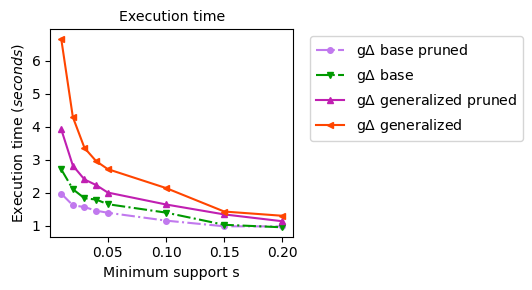

In [36]:
from utils_plot import plotDicts



info_plot = {}
for sup in out_time:
    for type_gen in out_time[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][sup] = out_time[sup][type_gen]
        
        
size_fig = (5.5,3)


info_i = "time"

figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title = 'Execution time', sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel="Execution time $(seconds)$", labelSize=10.2,\
         outside=True,  saveFig=True, nameFig = figure_name, legendSize=10.2)

## Plot max

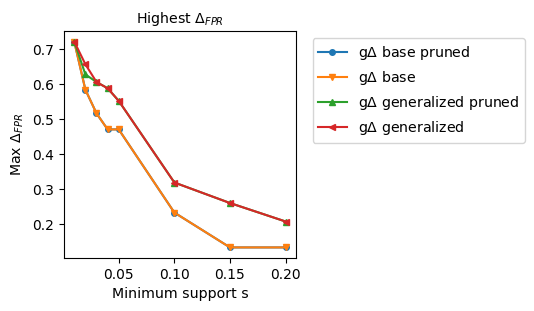

In [37]:
from utils_plot import plotDicts



info_plot = {}
for sup in out_support:

    for type_gen in out_support[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][sup] = out_support[sup][type_gen][metric].iloc[0]
        
        
size_fig = (3,3)


info_i = f"max_{metric}"

figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title="Highest $\\Delta_{FPR}$" , sizeFig=size_fig,
       #            linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel="Max $\\Delta_{FPR}$", labelSize=10.2,\
         outside=True,  saveFig=True, nameFig = figure_name, legendSize=10.2)

# Save results

In [344]:
save = True

In [36]:
import os

output_results = os.path.join(os.path.curdir, "output_results", 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)

In [37]:
if save:

    import json
    with open(os.path.join(output_results, f'{dataset_name}_{metric}_time.json'), 'w') as output_file:
         output_file.write(json.dumps(out_time))


    out_support_max = {}


    for sup in sorted(out_support.keys()):
        out_support_max[sup] = {}
        for type_gen in out_support[sup]:
            out_support_max[sup][type_gen] = out_support[sup][type_gen][metric].iloc[0]

    with open(os.path.join(output_results, f'{dataset_name}_{metric}_div.json'), 'w') as output_file:
         output_file.write(json.dumps(out_support_max))